# Body Parts Heatmaps

#### By Albert Gong

In [2]:
from scipy import misc
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np

import json
from pprint import pprint
import math

import cv2

%matplotlib inline

In [3]:
!pwd

/home/albert/openpose/albert


In [4]:
OPENPOSE_ROOT = '/home/albert/openpose/'

In [5]:
img = misc.imread(OPENPOSE_ROOT + '/examples/media/albert/woman.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
heatmap_img = misc.imread(OPENPOSE_ROOT + 'output_heatmaps_folder/woman_heatmaps.png')
render = misc.imread(OPENPOSE_ROOT + 'examples/media/albert/render/woman_rendered.png')

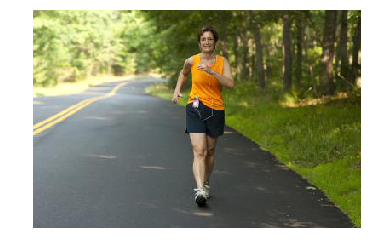

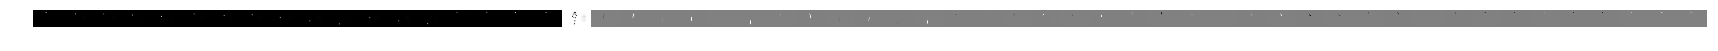

In [6]:
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(30,2))
plt.imshow(heatmap_img, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [7]:
print(img.shape)
print(heatmap_img.shape)

(256, 385, 3)
(368, 37392)


### Extracting Individual Heatmaps

In [8]:
def to_rgb(im):
    # as 1, but we use broadcasting in one line
    w, h = im.shape
    ret = np.zeros((w, h, 3), dtype=np.uint8)
    ret[:, :, :] = im[:, :, np.newaxis]
    return list(ret)

In [9]:
def subtract_by_min(im):
    return im - im.min()

In [10]:
def normalize(im):
    return (im * 255.0 / im.max()).astype(np.uint8)

In [11]:
def maintain_img_bounds(im):
    im_flat = np.emptyim.flatten()

In [12]:
heatmaps = []
htmp_height = heatmap_img.shape[0]
# 57 heatmaps: 18 bodypaf_x[0] + paf_y[0] parts + bkgd + 2 x 19 PAFs
htmp_width = int(heatmap_img.shape[1] / 57);

for i in range(0, 57):
    htmp = np.array(to_rgb(heatmap_img[:, i * htmp_width : (i + 1) * htmp_width]))
    htmp_resize = misc.imresize(htmp, float(img.shape[0]) / htmp_height)
    htmp_resize = htmp_resize[:, 0:img.shape[1]]
    heatmaps.append(htmp_resize)
    # plt.imshow(heatmaps[-1], cmap=plt.cm.gray)
    # plt.show()

bdy_pt_htmps = heatmaps[0:18]
bkgd = heatmaps[18]
# Invert background heatmap (use white background instead of black background)
# to produce heatmap with all body parts
all_bdy_pts = [255] - bkgd

pafs = heatmaps[19:]

paf_x = [heatmaps[i] for i in range(19, len(heatmaps), 2)]
paf_y = [heatmaps[i] for i in range(20, len(heatmaps), 2)]

paf_comb = [normalize(paf_x[i].astype(np.uint16) + paf_y[i].astype(np.uint16).astype(np.uint16)) 
            for i in range(len(paf_x))]

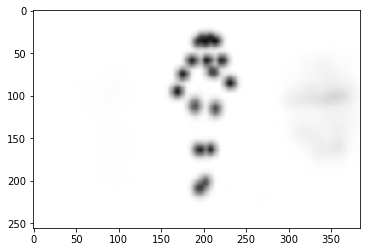

In [13]:
plt.imshow(bkgd)
plt.show()

### Processing Body Part Heatmaps

In [14]:
BODY_PARTS = [
    "Nose",
    "Neck",
    "RShoulder",
    "RElbow",
    "RWrist",
    "LShoulder",
    "LElbow",
    "LWrist",
    "RHip",
    "RKnee",
    "RAnkle",
    "LHip",
    "LKnee",
    "LAnkle",
    "REye",
    "LEye",
    "REar",
    "LEar",
    "Bkg",
]

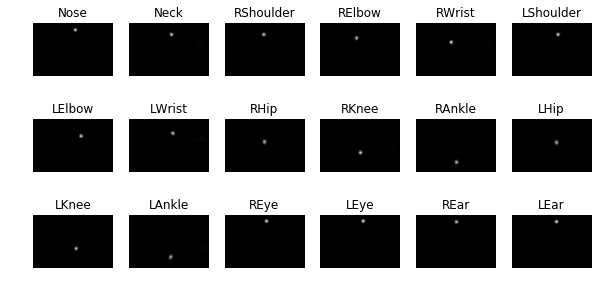

In [15]:
plt.figure(figsize=(10, 5))

for i in range(len(bdy_pt_htmps)):
    plt.subplot(3, 6, i + 1)
    plt.imshow(bdy_pt_htmps[i])
    plt.title(BODY_PARTS[i])
    plt.axis("off")

plt.show()

In [16]:
def reduce_radius(im, r_factor):
#     Use dtype=np.uint8, since images are stored as numpy arrays of dtype=np.uint8
#     Otherwise images do not show properly; addition of numpy arrays results
#     in values being cast to the "highest" type
    reduced_im = np.floor(im * r_factor).astype(np.uint8)
    return reduced_im

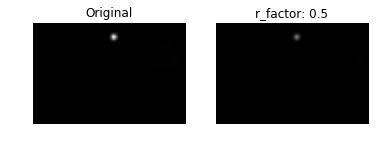

In [17]:
nose_htmp = bdy_pt_htmps[BODY_PARTS.index("Nose")]
plt.subplot(1, 2, 1)
plt.imshow(nose_htmp)
plt.title("Original")
plt.axis("off")

r_factor = 0.5

plt.subplot(1, 2, 2)
plt.imshow(reduce_radius(nose_htmp, r_factor))
plt.title("r_factor: %s" % r_factor)
plt.axis("off")

plt.show()

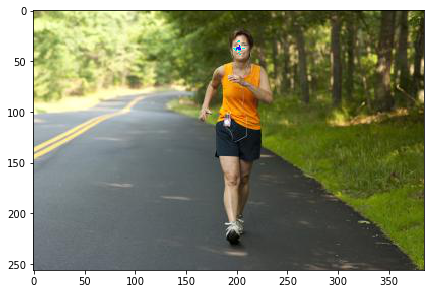

In [18]:
img_with_filter = img + reduce_radius(nose_htmp, r_factor)
plt.figure(figsize=(7,7))
plt.imshow(img_with_filter)
plt.show()

### Processing PAFs

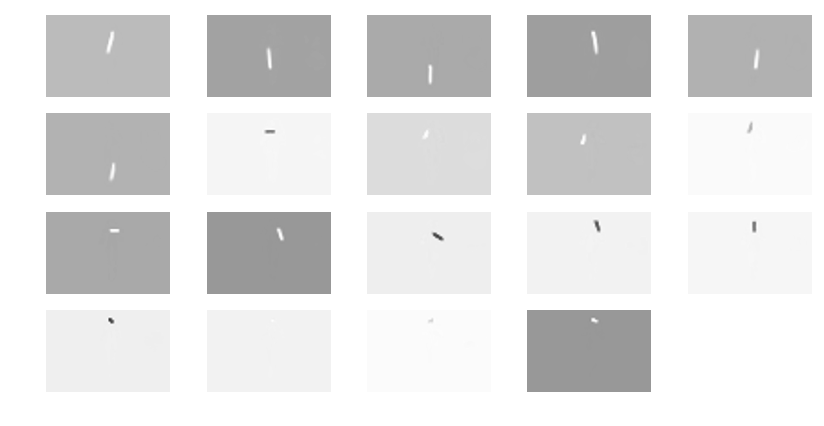

In [19]:
plt.figure(figsize=(10,5), dpi=100)
for i in range(len(paf_comb)):
    plt.subplot(4, 5, i + 1)
    plt.imshow(paf_comb[i])
    plt.axis("off")
plt.show()

In [20]:
n_pafs = 18
all_pafs = np.zeros(paf_comb[0].shape, dtype=np.uint8)

for i in range(n_pafs):
    all_pafs += paf_comb[i]

print(all_pafs.max())
# print(all_pafs[350:500, 0:200])
# all_pafs = normalize(all_pafs)

255


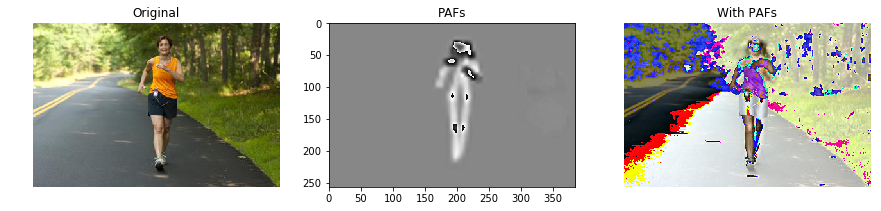

In [21]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(all_pafs)
plt.title("PAFs")
# plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img + all_pafs)
plt.title("With PAFs")
plt.axis("off")

plt.show()

In [22]:
paf_comb_gray = []
for i in range(len(paf_comb)):
    paf_comb_gray.append(cv2.cvtColor(paf_comb[i], cv2.COLOR_BGR2GRAY))

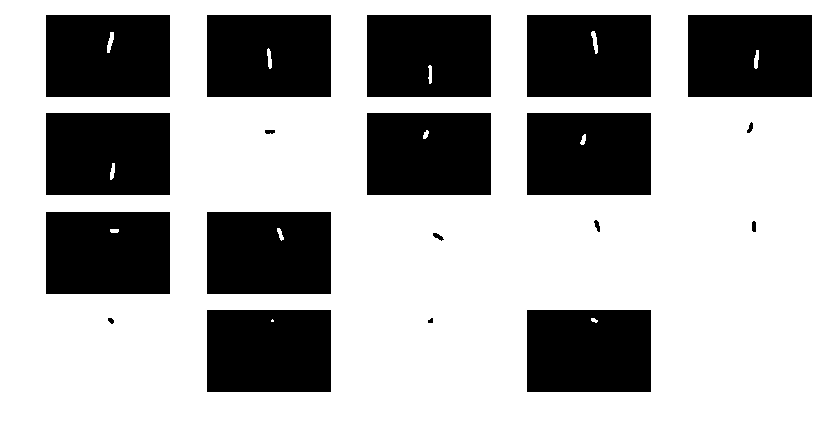

In [33]:
plt.figure(figsize=(10,5), dpi=100)
for i in range(len(paf_comb_gray)):
    plt.subplot(4, 5, i + 1)
    ret, thresh = cv2.threshold(paf_comb_gray[i],0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    plt.imshow(thresh, cmap=plt.cm.gray)
    plt.axis("off")
plt.show()

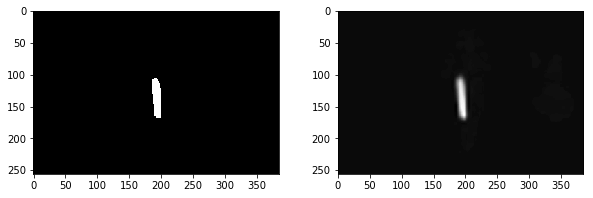

In [30]:
kernel = np.ones((3,3),np.uint8)
# http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.imshow(opening, cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(paf_comb_gray[n], cmap=plt.cm.gray)
plt.show()

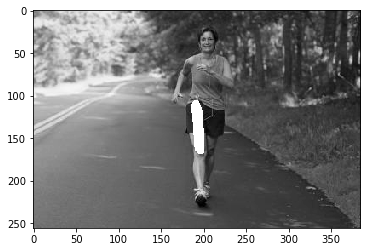

In [31]:
overlay = np.maximum(gray, opening)
plt.imshow(overlay, cmap=plt.cm.gray)